In [1]:
import numpy as np
import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.callbacks import Callback
from keras.optimizers import Adam
import pandas as pd
import pickle
from os import listdir
import cv2
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



In [2]:
# Helper functions

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)

def shuffle_in_unison(x, y, seed):
    assert len(x) == len(y)
    np.random.seed(seed)
    p = np.random.permutation(len(x))
    return x[p], y[p]

class WeightsSaver(Callback):
    def __init__(self, init_epoch, N, frozen):
        self.N = N
        self.frozen = frozen
        self.epoch = init_epoch
    
    def on_epoch_end(self, epoch, logs={}):
        if self.epoch % self.N == 0:
            if self.frozen:
                name = 'weights/weights%08d_frozen.h5' % self.epoch
            else:
                name = 'weights/weights%08d.h5' % self.epoch
            self.model.save_weights(name)
        self.epoch += 1

In [3]:
# Read labels

train_df = pd.read_csv('../data/trainLabels.csv', engine='python')

In [24]:
# chosen model
chosen_model_no = 1
resize = True

no_examples = 50_000
no_classes = 10
if resize:
    img_height = 32 * 2
    img_width = 32 * 2
else:
    img_height = 32
    img_width = 32
vgg_height = 224
vgg_width = 224
img_channels = 3
path_to_imgs = '../data/train/'

In [5]:
# Read images and append them to train_df

img_df = np.zeros((no_examples, img_height, img_width, img_channels))
for img_name in listdir(path_to_imgs):
    no = int(img_name.split('.')[0]) - 1
    img = load_img(path_to_imgs + img_name, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = preprocess_input(img)
    img_df[no] = img


In [6]:
# Let's replace labels with 0-9 numbers and do one-hot encoding

labels_dict = list(pd.unique(train_df['label']))
labels_dict = dict(zip(labels_dict, range(no_classes)))
labels = np.zeros((no_examples, no_classes))
for i, elem in enumerate(train_df['label']):
    labels[i][labels_dict[elem]] = 1
    
# Shuffle datasets
img_df, labels = shuffle_in_unison(img_df, labels, seed=1)
train_img = img_df[:40000]
validation_img = img_df[40000:]
train_labels = labels[:40000]
validation_labels = labels[40000:]

In [7]:
# Data generator to improve data
train_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

validation_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_gen.fit(train_img)
validation_gen.fit(validation_img)

In [25]:
# Let's try to use VGG19 to make predictions on our set.
# We replace dense layers in VGG19 with our own

vgg19 = keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, img_channels))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential(layers=vgg19.layers)

if chosen_model_no == 1:
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
elif chosen_model_no == 2:

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

opt = Adam(learning_rate=0.001, beta_1=0.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
model.summary()
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

load_from_file = True
if load_from_file:
    model.load_weights('./network_6/weights/weights00000150.h5')
    with open('network_4/trainHistory', 'rb') as file:
        history = pickle.load(file)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

In [10]:
# Training frozen model
current_history = model.fit_generator(
    train_gen.flow(train_img, train_labels, batch_size=16),
    validation_data = validation_gen.flow(
        validation_img,
        validation_labels,
        batch_size=16),
    validation_steps = 10_000 // 16,
    initial_epoch=0,
    epochs=30,
    callbacks=[WeightsSaver(0, 50, False)])

history['val_loss'] += current_history.history['val_loss']
history['loss'] += current_history.history['loss']
history['val_accuracy'] += current_history.history['val_accuracy']
history['accuracy'] += current_history.history['accuracy']
history_path = './trainHistory'
with open(history_path, 'wb') as hist_file:
        pickle.dump(history, hist_file)

Epoch 1/30
2500/2500 [==============================] - 139s 56ms/step - loss: 1.2757 - accuracy: 0.7079 - val_loss: 1.1020 - val_accuracy: 0.7295
Epoch 2/30
2500/2500 [==============================] - 130s 52ms/step - loss: 0.7316 - accuracy: 0.7622 - val_loss: 0.7227 - val_accuracy: 0.7612
Epoch 3/30
2500/2500 [==============================] - 125s 50ms/step - loss: 0.6619 - accuracy: 0.7855 - val_loss: 0.2535 - val_accuracy: 0.7615
Epoch 4/30
2500/2500 [==============================] - 124s 50ms/step - loss: 0.6265 - accuracy: 0.7981 - val_loss: 0.5046 - val_accuracy: 0.7758
Epoch 5/30
2500/2500 [==============================] - 124s 50ms/step - loss: 0.5866 - accuracy: 0.8124 - val_loss: 1.2140 - val_accuracy: 0.7597
Epoch 6/30
2500/2500 [==============================] - 127s 51ms/step - loss: 0.5610 - accuracy: 0.8217 - val_loss: 0.9260 - val_accuracy: 0.7849
Epoch 7/30
2500/2500 [==============================] - 130s 52ms/step - loss: 0.5279 - accuracy: 0.8324 - val_loss: 0

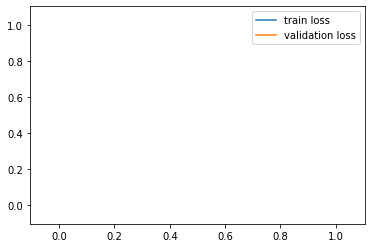

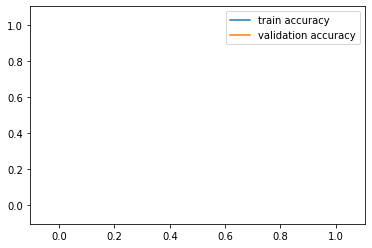

{'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


In [23]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

print(history)

In [42]:
# Let's unfreeze vgg layers and train again
for layer in vgg19.layers:
    layer.trainable = True

unfrozen_model = Sequential(layers=model.layers)
unfrozen_model.build((None, img_height, img_width, img_channels))
opt = Adam(learning_rate=0.00001, beta_1=0.9)
unfrozen_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
unfrozen_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

In [21]:
current_history = unfrozen_model.fit_generator(
    train_gen.flow(train_img, train_labels, batch_size=16),
    validation_data = validation_gen.flow(
        validation_img,
        validation_labels,
        batch_size=16),
    validation_steps = 10_000 // 16,
    initial_epoch=111,
    epochs=151,
    callbacks=[WeightsSaver(111, 50, False)])

history['val_loss'] += current_history.history['val_loss']
history['loss'] += current_history.history['loss']
history['val_accuracy'] += current_history.history['val_accuracy']
history['accuracy'] += current_history.history['accuracy']
history_path = './trainHistory'
with open(history_path, 'wb') as hist_file:
        pickle.dump(history, hist_file)

Epoch 112/151
2500/2500 [==============================] - 280s 112ms/step - loss: 0.0188 - accuracy: 0.9948 - val_loss: 1.1482 - val_accuracy: 0.9214
Epoch 113/151
2500/2500 [==============================] - 278s 111ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.0331 - val_accuracy: 0.9181
Epoch 114/151
2500/2500 [==============================] - 276s 110ms/step - loss: 0.0179 - accuracy: 0.9954 - val_loss: 0.3014 - val_accuracy: 0.9226
Epoch 115/151
2500/2500 [==============================] - 276s 110ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.9027 - val_accuracy: 0.9200
Epoch 116/151
2500/2500 [==============================] - 276s 110ms/step - loss: 0.0156 - accuracy: 0.9955 - val_loss: 0.5903 - val_accuracy: 0.9213
Epoch 117/151
2500/2500 [==============================] - 276s 110ms/step - loss: 0.0186 - accuracy: 0.9952 - val_loss: 1.3953 - val_accuracy: 0.9201
Epoch 118/151
2500/2500 [==============================] - 274s 110ms/step - loss: 0.0218 - ac

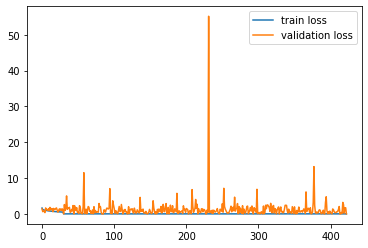

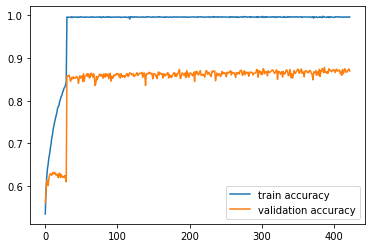

In [39]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history['accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [43]:
# Check results on test set
path_to_imgs_test = '../data/test/'
def get_test_predictions(model, path):
    no_examples_test = 300_000
    predictions = np.zeros((no_examples_test, 1), dtype=int)
    i = 0
    for img_name in listdir(path):
        no = int(img_name.split('.')[0]) - 1
        img = load_img(path + img_name, target_size=(img_height, img_width))
        img = img_to_array(img)
        img = preprocess_input(img)
        predictions[no] = np.argmax(model.predict(img[None, :, :, :]), axis=1)
        i += 1
        if i % 100 == 0:
            print(f'\riteration {i}/{no_examples_test}', end='')
    return predictions

results = get_test_predictions(unfrozen_model, path_to_imgs_test)

iteration 300000/300000

In [44]:
# Save results as csv

label_decoder = [
    'frog',
    'truck',
    'deer',
    'automobile',
    'bird',
    'horse',
    'ship',
    'cat',
    'dog',
    'airplane'
]
results_encoded = [label_decoder[i] for i in results.flatten()]
results_df = pd.DataFrame(results_encoded)
results_df.columns = ['label']
results_df.index.name = 'id'
results_df.index += 1
results_df.to_csv('results.csv')

In [26]:
def get_confusion_matrix(x, y, model, no_labels=10):
    assert x.shape[0] == y.shape[0]
    if y.shape[1] != 1: # 0-9 encoding
        y = np.argmax(y, axis=1)
    else:
        y = y.flatten() # one-hot encoding
    confusion_matrix = np.zeros((no_labels, no_labels)).astype(int)
    pred = np.argmax(model.predict(x), axis=1)
    for i in range(pred.shape[0]):
        confusion_matrix[pred[i], y[i]] += 1
    return confusion_matrix

In [27]:
m = get_confusion_matrix(validation_img, validation_labels, model)
print(m)

y.shape=(10000,)
y=[4 9 1 ... 7 6 9]
pred = [4 0 1 ... 7 6 4]
[[975   2  13   0  21   1   1  38   8   2]
 [  0 964   0  35   0   1   7   2   2   8]
 [  5   1 928   0  14  10   1  17  15   2]
 [  0  13   0 934   2   0   8   2   1   3]
 [ 15   2  17   0 927   8   1  32  11   7]
 [  1   0  31   0   2 969   0  19  33   0]
 [  3   4   3   4   4   0 992   8   1  30]
 [  4   5   9   1   7  10   0 779  66   1]
 [  2   0  13   0   5   3   0  82 853   0]
 [  3   6   4   1  24   5   7   4   2 944]]


0.0